In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='SimHei') # 设置字体为黑体
plt.rc('axes', unicode_minus=False) # 解决坐标轴负号显示问题


In [2]:
#全局变量定义
global P_load # 电负荷
global WT # 风电
global PV # 光伏
global buy_price # 买入电价
global sell_price # 售出电价

In [3]:
#获取数据
data=pd.read_csv("mopso_data.csv")
P_load=data["电负荷（MW）"] #负荷预测 
PV=data["光伏（MW）"]  #光伏预测
WT=data["风电(MW)"]  #风电预测
buy_price=data["向电网买电价"]
sell_price=data["向电网卖电价"]

In [4]:
#数值约束
#正表示为电负荷供电
BESSMax_dischar = 30 #蓄电池最大放电功率
BESSMax_char = -30 #蓄电池最大充电功率
DEMax = 30    #柴油机最大发电功率
DEMin = 6    #柴油机最小发电功率
MTMax = 30   #燃气轮机最大发电功率
MTMin = 3    #燃气轮机最小发电功率
GridMax = 30  #主网交互最大功率
GridMin = -30 #主网交互最小功率

In [5]:
#适应度函数
def fitness(x):
    
    #柴油机
    DE_sum = 0
    for i in range(73, 96):
        DE_temp = abs(x[i+1] - x[i])
        DE_sum += DE_temp
    
    f_DE = 0

    if DE_sum <= 345:
        f_DE = 0
    elif DE_sum > 345 and DE_sum <= 400:
        f_DE = 2 # 迭代次数
    elif DE_sum > 445 and DE_sum <= 500:
        f_DE = 5
    else:
        f_DE = 20
    
    
    
    f_MT=0
    MT_sum = 0
    MT_temp = np.zeros(144)

    for i in range(97, 120):
        MT_temp[i] = abs(x[i + 1] - x[i])
        MT_sum += MT_temp[i]

    f_MT = 0
    # MT爬坡阶梯惩罚系数(未满足爬坡约束惩罚)
    if MT_sum <= 345:
        f_MT = 0
    elif 345 < MT_sum <= 400:
        f_MT = 2  # 迭代次数
    elif 445 < MT_sum <= 500:
        f_MT = 5
    else:
        f_MT = 20
    
    
    #储能SOC
    SOCMax = 150
    SOCMin = 5
    SOC_sum = 50 # 初始容量
    SOC_sum_delt = 0
    n = 0.9 # 充放电效率

    for i in range(49, 73):
        if x[i] > 0: # 充放电
            n = -1 / 0.9
        else:
            n = 0.9
    SOC_sum += n * x[i]

    if SOC_sum > SOCMax:
        SOC_sum_delt += max(0, SOC_sum - SOCMax)

    if SOC_sum < SOCMin:
        SOC_sum_delt += abs(SOC_sum - SOCMin)
    f_SOC = 0.05
    #SOC容量阶梯惩罚系数(未满足SOC约束惩罚)
    if SOC_sum_delt <= 0:
        f_SOC = 0
    elif SOC_sum_delt > 0 and SOC_sum_delt <= 10:
        f_SOC = 1 # 迭代次数
    elif SOC_sum_delt > 10 and SOC_sum_delt < 50:
        f_SOC = 2
    elif SOC_sum_delt > 50 and SOC_sum_delt <= 100:
        f_SOC = 5
    else:
        f_SOC = 20
        
    
    
    #电功率平衡处理
    ele_sum = 0
    for i in range(24):
        ele_temp = abs(x[i] + x[i+24] + x[i+48] + x[i+72] + x[i+96] + x[i+120] - P_load[i])
        ele_sum += ele_temp
    f_ele = 0
    if ele_sum == 0:
        f_ele = 0.0
    elif ele_sum > 0 and ele_sum <= 100:
        f_ele = 1
    elif ele_sum > 100 and ele_sum <= 500:
        f_ele = 5
    elif ele_sum > 500 and ele_sum <= 800:
        f_ele = 10
    else:
        f_ele = 50
    
    #判断是否为可行解
    if ele_sum>4500:
        c=1
    else:
        c=0 
    
    #目标函数1——经济成本
    C_DE = 0
    C_BESS = 0
    C_MT = 0

    for i in range(144):
        if i > 48 and i < 73:
            C_BESS += (0.026) * abs(x[i]) # 运维成本
        elif i > 72 and i < 97:
            C_DE += (0.128 * x[i]) + (0.00011 * x[i]**2 + 0.180 * x[i] + 6) # 运维成本 && 燃料成本
        elif i > 96 and i < 121:
            C_MT += (0.0293 * x[i]) + (2.55 / 9.8 * x[i]) / (0.0753 * x[i]**3 - 0.3095 * x[i]**2 + 0.4174 * x[i] + 0.1068) # 运维成本 && 燃料成本

    C_OM_F = C_DE + C_MT + C_BESS
    
    #电网电价成本
    C_grid = 0
    for i in range(121, 144):
        if x[i] > 0:
            C_grid += buy_price[i-120] * x[i]
        else:
            C_grid -= sell_price[i-120] * x[i]
    result_1 = C_grid + C_OM_F + f_DE * DE_sum + f_MT * MT_sum + f_SOC * SOC_sum_delt + f_ele * ele_sum  #经济成本
    
    
    
    #目标函数2---环境成本
    result_2=0
    for i in range(121,145):
        #三种污染气体

            CO=x[i-96]*724+x[i-120]*922
            SO=x[i-96]*0.0036+x[i-120]*2.295
            NO=x[i-96]*0.2+x[i-120]*3.583
            
            C_e=CO*0.21+SO*14.824+NO*62.964 
            
            result_2+=C_e
    

    return result_1,result_2

In [6]:
#多目标粒子群算法

n=144
lower_bound = np.zeros(n)
upper_bound = np.zeros(n)
#初始化上下限
for i in range(n):
    if i < 24:
        lower_bound[i] = 0
        upper_bound[i] = PV[i]
    elif 24 < i < 48:
        lower_bound[i] = 0
        upper_bound[i] = WT[i - 24]
    elif 48 < i < 72:
        lower_bound[i] = BESSMax_char
        upper_bound[i] = BESSMax_dischar
    elif 72 < i < 96:
        lower_bound[i] = DEMin
        upper_bound[i] = DEMax
    elif 96 < i < 121:
        lower_bound[i] = MTMin
        upper_bound[i] = MTMax
    else:
        lower_bound[i] = GridMin
        upper_bound[i] = GridMax

In [16]:
class MOPSO:
    def __init__(self, num_particles, num_dimensions, max_iterations, lower_bound, upper_bound):
        self.num_particles = num_particles
        self.num_dimensions = num_dimensions
        self.max_iterations = max_iterations
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
        # 初始化粒子位置和速度
        self.positions = np.random.uniform(lower_bound, upper_bound, size=(num_particles, num_dimensions))
        self.velocities = np.random.uniform(-1, 1, size=(num_particles, num_dimensions))
        
        # 初始化粒子的个体最优解和全局最优解
        self.pbest_positions = self.positions.copy()  #局部
        self.pbest_scores = np.full((num_particles, 2), np.inf)
        self.gbest_position = None  #全局
        self.gbest_score = (np.inf,np.inf)
    
    def optimize(self):
        #print(self.gbest_score)
        for iteration in range(self.max_iterations):
            for i in range(self.num_particles):
                # 计算当前粒子的目标函数值
                scores = fitness(self.positions[i])
                print(scores)
                # 更新粒子的个体最优解和全局最优解
                if  all(scores <= self.pbest_scores[i]):
                    self.pbest_scores[i] = scores
                    self.pbest_positions[i] = self.positions[i]
                #环境 经济协同调度 
                
                if (np.sum(scores)<= np.sum(self.gbest_score)):
                    self.gbest_score = scores
                    self.gbest_position = self.positions[i]
                
                #经济调度
                """
                if (scores[0]<=self.gbest_score[0]):
                    self.gbest_score = scores
                    self.gbest_position = self.positions[i]
                """
                #环境调度
                """
                if (scores[1]<=self.gbest_score[1]):
                    self.gbest_score = scores
                    self.gbest_position = self.positions[i]
                """
                # 更新粒子的速度和位置
                r1 = np.random.rand(self.num_dimensions)
                r2 = np.random.rand(self.num_dimensions)
                self.velocities[i] = self.velocities[i] + r1 * (self.pbest_positions[i] - self.positions[i]) + r2 * (self.gbest_position - self.positions[i])
                
                # 限制速度在[-1, 1]范围内
                self.velocities[i] = np.clip(self.velocities[i], -1, 1)
                
                # 更新粒子位置，并限制在上下限范围内
                self.positions[i] = self.positions[i] + self.velocities[i]
                self.positions[i] = np.clip(self.positions[i], self.lower_bound, self.upper_bound)
        
        
    def print_solution(self):
        #打印优化结果
        print("Final population:")
        print(self.gbest_score,self.gbest_position)
        
        """
        for i in range(self.num_particles):
            print("Particle", i, ": Position =", self.positions[i], "Scores =", self.pbest_scores[i])
        """
        return self.gbest_score,self.gbest_position

In [17]:
num_particles = 50
num_dimensions = 144
max_iterations = 10

In [18]:
mopso = MOPSO(num_particles, num_dimensions, max_iterations, lower_bound, upper_bound)
mopso.optimize()

(45433.27947622516, 20850.80869965853)
(43635.96884930111, 27976.37577188523)
(43366.48850040383, 23062.51822375773)
(6907.327347625031, 43456.024185488335)
(7499.835253136847, 30723.231473183845)
(7822.0635685036195, 30211.904474898325)
(8395.601450264952, 17498.561341594832)
(40976.25905607954, 34012.08369718731)
(7195.365841966283, 42394.4027083905)
(7511.603111154388, 42057.419379496234)
(45680.56944289801, 30878.64663918893)
(6690.662410956339, 38755.584056269945)
(48413.84588969138, 32403.307758505645)
(8458.7802377525, 33066.84952951659)
(42423.50043763305, 35912.93966656668)
(47297.99914881181, 17908.6027875886)
(45964.91893178448, 38225.57051206376)
(7646.478134657617, 23448.189208985958)
(44921.66295459463, 35257.499348735044)
(49817.0104631401, 18265.28572962263)
(47681.28478108237, 20609.571821737845)
(46726.25458148237, 20260.03928530634)
(47533.99157571306, 23123.823050824674)
(43701.610708421285, 24579.99404709688)
(42961.20304395301, 18966.204900240482)
(44629.633255251

(6694.991432275164, 31921.67682140222)
(7294.7466623885, 21044.00423435285)
(7632.678827956513, 18917.532168847283)
(7985.6890765579665, 10921.875932079636)
(7458.150377051863, 23150.848516271566)
(6815.103855119435, 30295.52902293097)
(6911.941836615953, 26867.2045148888)
(40879.53839486651, 22288.425633780073)
(6429.358821022494, 29352.3439366503)
(44927.328413849995, 19343.03794431613)
(8192.665999060908, 24177.677698643183)
(7832.023228167558, 28360.355001411714)
(42473.33369910309, 10844.9138002131)
(40857.40235532859, 30007.25729249625)
(7397.551807782959, 22811.960082204856)
(7852.146199361347, 29081.22877634549)
(43800.010899319605, 11887.476119077073)
(43297.59898040883, 11355.242664727914)
(8452.64025734074, 11618.632001767619)
(44184.84141719642, 14787.256151336755)
(7948.758734345105, 21636.013363433332)
(40876.1547482882, 13956.127659137928)
(8000.664650200265, 8569.026546837247)
(42216.87594204678, 16609.633357128063)
(6857.989524684379, 15589.334512930443)
(7649.29726810

In [19]:
result,pg=mopso.print_solution()

Final population:
(7029.636574000033, 5280.040998390374) [  0.           0.           0.           0.           0.
   0.           0.           0.           4.           2.29785514
   3.07569221   0.           7.05746429  12.4773344    0.79595681
   1.53081606   1.           0.           0.           0.
   0.           0.           0.           0.         -29.87988639
   0.93835282   0.13781141   1.69378917   0.           0.99577896
   0.           0.66222709   2.           0.           3.95328153
   6.73802025   2.61715431   0.           0.           1.
   1.8031534    0.           1.03905751   1.06411341   2.5
   2.5          2.           0.9722748   -9.09964494 -12.37363306
 -27.88499196  -1.1283406  -18.53786519   4.65819944  29.26144079
   3.75987913 -13.55612556  24.36298901   7.68386007   4.66778651
 -29.54989469  30.         -22.55885941   4.34203667  19.41657557
  13.93995047  19.22621422  19.69505615  26.56998479  15.22574612
  25.62320556 -13.19651169  10.26919651   7.629850

In [20]:
#结果储存
pg_PV = [0] * 24 #光伏
pg_WT = [0] * 24 #风电
pg_BESS = [0] * 24 #蓄电池
pg_DE = [0] * 24 #柴油
pg_MT = [0] * 24 #燃油发电机
pg_grid = [0] * 24 #主网

for i in range(24):
    pg_PV[i] = pg[i]

for m in range(25, 49):
    pg_WT[m-25] = pg[m]

for m in range(49, 73):
    pg_BESS[m-49] = pg[m]

for m in range(73, 97):
    pg_DE[m-73] = pg[m]

for m in range(97, 121):
    pg_MT[m-97] = pg[m]

for m in range(121, 144):
    pg_grid[m-121] = pg[m]

C:\Users\85074\AppData\Local\Temp\ipykernel_9820\2454451964.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r^" (-> color='r'). The keyword argument will take precedence.
  plt.plot(pg_PV, '-r^', color='red', linewidth=1, markeredgecolor='black', markerfacecolor='blue', markersize=5)
C:\Users\85074\AppData\Local\Temp\ipykernel_9820\2454451964.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--g<" (-> color='g'). The keyword argument will take precedence.
  plt.plot(PV, '--g<', color='red', linewidth=1, markeredgecolor='magenta', markerfacecolor='magenta', markersize=5)


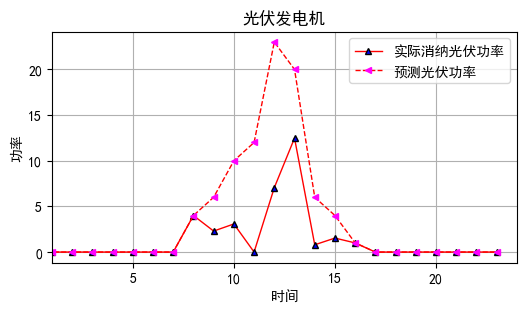

In [21]:
#光伏功率曲线
plt.figure(figsize=(6,3))

plt.plot(pg_PV, '-r^', color='red', linewidth=1, markeredgecolor='black', markerfacecolor='blue', markersize=5)
#plt.hold(True)
plt.plot(PV, '--g<', color='red', linewidth=1, markeredgecolor='magenta', markerfacecolor='magenta', markersize=5)

plt.xlim([1, 24])
plt.grid(True)
plt.legend(['实际消纳光伏功率', '预测光伏功率'])
plt.xlabel('时间')
plt.ylabel('功率')
plt.title('光伏发电机')

plt.show()

C:\Users\85074\AppData\Local\Temp\ipykernel_9820\1584929460.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-mh" (-> color='m'). The keyword argument will take precedence.
  plt.plot(pg_WT, '-mh', color=[1, 1, 0], linewidth=1, markeredgecolor='c', markerfacecolor=[0, 0, 1], markersize=5)
C:\Users\85074\AppData\Local\Temp\ipykernel_9820\1584929460.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--ms" (-> color='m'). The keyword argument will take precedence.
  plt.plot(WT, '--ms', color=[1, 0, 1], linewidth=1, markeredgecolor='c', markerfacecolor=[0, 0, 1], markersize=5)


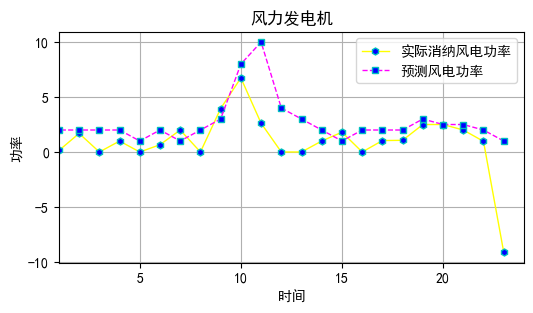

In [22]:
#风力功率曲线
plt.figure(figsize=(6,3))
plt.plot(pg_WT, '-mh', color=[1, 1, 0], linewidth=1, markeredgecolor='c', markerfacecolor=[0, 0, 1], markersize=5)
plt.plot(WT, '--ms', color=[1, 0, 1], linewidth=1, markeredgecolor='c', markerfacecolor=[0, 0, 1], markersize=5)
plt.xlim([1, 24])
plt.grid(True)
plt.legend(['实际消纳风电功率', '预测风电功率'])
plt.xlabel('时间')
plt.ylabel('功率')
plt.title('风力发电机')
plt.show()

C:\Users\85074\AppData\Local\Temp\ipykernel_9820\3790053315.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-rs" (-> color='r'). The keyword argument will take precedence.
  plt.plot(pg_DE, '-rs', color=[1, 0, 1], linewidth=1, markeredgecolor='m', markerfacecolor=[0, 1, 1], markersize=5)


Text(0.5, 1.0, '柴油发电机')

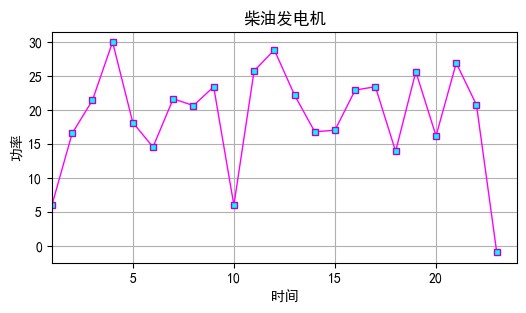

In [23]:
plt.figure(figsize=(6,3))
plt.plot(pg_DE, '-rs', color=[1, 0, 1], linewidth=1, markeredgecolor='m', markerfacecolor=[0, 1, 1], markersize=5)
plt.xlim([1, 24])
plt.grid(True)
plt.xlabel('时间')
plt.ylabel('功率')
plt.title('柴油发电机')

C:\Users\85074\AppData\Local\Temp\ipykernel_9820\1409420752.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-y<" (-> color='y'). The keyword argument will take precedence.
  plt.plot(pg_BESS, '-y<', color=[1, 1, 0], linewidth=1, markeredgecolor='m', markerfacecolor=[1, 0, 0], markersize=5)


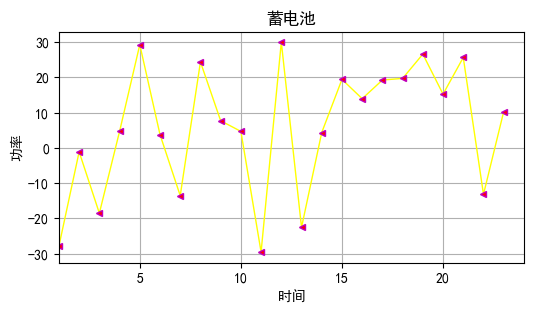

In [24]:
plt.figure(figsize=(6,3))
plt.plot(pg_BESS, '-y<', color=[1, 1, 0], linewidth=1, markeredgecolor='m', markerfacecolor=[1, 0, 0], markersize=5)
plt.xlim([1, 24])
plt.grid(True)
plt.xlabel('时间')
plt.ylabel('功率')
plt.title('蓄电池')

plt.show()

C:\Users\85074\AppData\Local\Temp\ipykernel_9820\3075784956.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ch" (-> color='c'). The keyword argument will take precedence.
  plt.plot(P_load, '-ch', color=[0, 1, 0], linewidth=1, markeredgecolor='m', markerfacecolor=[0, 0, 1], markersize=5)


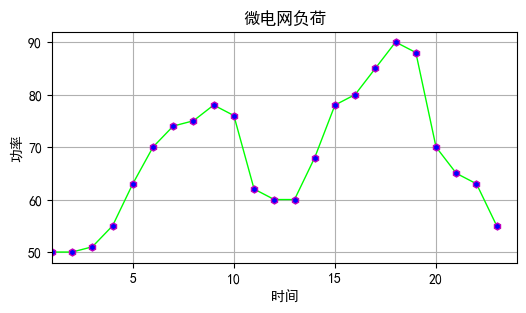

In [25]:
plt.figure(figsize=(6,3))
plt.plot(P_load, '-ch', color=[0, 1, 0], linewidth=1, markeredgecolor='m', markerfacecolor=[0, 0, 1], markersize=5)
plt.xlim([1, 24])
plt.grid(True)
plt.xlabel('时间')
plt.ylabel('功率')
plt.title('微电网负荷')

plt.show()

C:\Users\85074\AppData\Local\Temp\ipykernel_9820\3466441146.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-m<" (-> color='m'). The keyword argument will take precedence.
  plt.plot(pg_MT, '-m<', color=[0, 1, 0], linewidth=1, markeredgecolor='g', markerfacecolor=[1, 0, 1], markersize=5)


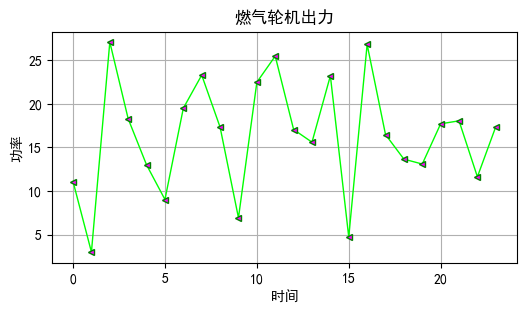

In [26]:
plt.figure(figsize=(6,3))
plt.plot(pg_MT, '-m<', color=[0, 1, 0], linewidth=1, markeredgecolor='g', markerfacecolor=[1, 0, 1], markersize=5)
plt.grid(True)
plt.xlabel('时间')
plt.ylabel('功率')
plt.title('燃气轮机出力')

plt.show()

C:\Users\85074\AppData\Local\Temp\ipykernel_9820\3663865843.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-rs" (-> color='r'). The keyword argument will take precedence.
  plt.plot(pg_grid, '-rs', color=[1, 1, 0], linewidth=1, markeredgecolor='m', markerfacecolor=[0, 0, 1], markersize=5)


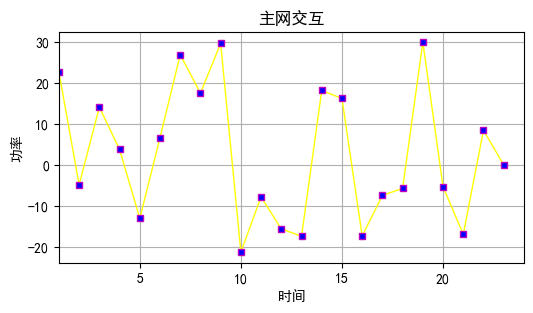

In [27]:
plt.figure(figsize=(6,3))
plt.plot(pg_grid, '-rs', color=[1, 1, 0], linewidth=1, markeredgecolor='m', markerfacecolor=[0, 0, 1], markersize=5)
plt.xlim([1, 24])
plt.grid(True)
plt.xlabel('时间')
plt.ylabel('功率')
plt.title('主网交互')

plt.show()

Text(0, 0.5, '功率/kW')

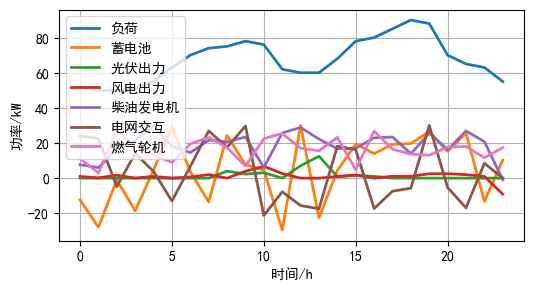

In [28]:
plt.figure(figsize=(6,3))
plt.plot(P_load, linewidth=2)
plt.plot(pg_BESS, linewidth=2)
plt.plot(pg_PV, linewidth=2)
plt.plot(pg_WT, linewidth=2)
plt.plot(pg_DE, linewidth=2)
plt.plot(pg_grid, linewidth=2)
plt.plot(pg_MT, linewidth=2)
plt.grid(True)
plt.legend(['负荷', '蓄电池', '光伏出力', '风电出力', '柴油发电机', '电网交互', '燃气轮机'])
plt.xlabel('时间/h')
plt.ylabel('功率/kW')
#plt.title()



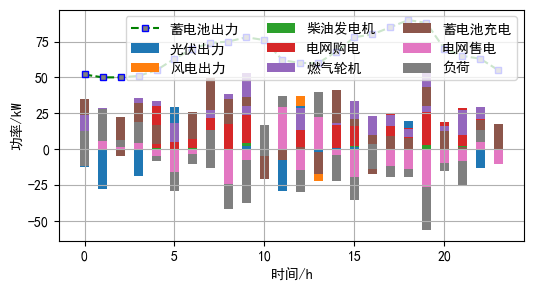

In [29]:
plt.figure(figsize=(6,3))
positive = np.vstack([pg_BESS, pg_PV, pg_WT, pg_DE, pg_grid, pg_MT])
negative = np.vstack([-np.array(pg_BESS), -np.array(pg_grid)])
bar_positions = np.arange(24)
bar_width = 0.5

plt.bar(bar_positions, positive[0], width=bar_width)
#plt.bar(bar_positions, positive[1], width=bar_width, bottom=np.cumsum(positive[:-1], axis=0))
plt.bar(bar_positions, positive[1], width=bar_width, bottom=positive[0])
plt.bar(bar_positions, positive[2], width=bar_width, bottom=positive[1])
plt.bar(bar_positions, positive[3], width=bar_width, bottom=positive[2])
plt.bar(bar_positions, positive[4], width=bar_width, bottom=positive[3])
plt.bar(bar_positions, positive[5], width=bar_width, bottom=positive[4])

plt.bar(bar_positions, negative[0], width=bar_width)
#plt.bar(bar_positions, negative[1:], width=bar_width, bottom=np.cumsum(negative[:-1], axis=0))
plt.bar(bar_positions, negative[1], width=bar_width, bottom=negative[0])

plt.plot(P_load, '--gs', linewidth=1.5, markersize=5, markeredgecolor='b', markerfacecolor=[0.5, 0.5, 0.5])
plt.legend(['蓄电池出力', '光伏出力', '风电出力', '柴油发电机', '电网购电', '燃气轮机', '蓄电池充电', '电网售电', '负荷'],
fontsize=10, ncol=3)
plt.xlabel('时间/h')
plt.ylabel('功率/kW')
plt.grid(1)

plt.show()